In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import numpy as np

from cassL import camb_interface as ci
from cassL import user_interface as ui

import camb
from camb import model, initialpower

import copy as cp

In [2]:
omega_index = 1 # while we debug, we confine our attention to just one value
omnuh2_float = ci.OMNUH2_FLOATS[omega_index]
omnuh2_str = ci.OMNUH2_STRS[omega_index]

In [3]:
skips_omega = cp.deepcopy(ci.OMNUH2_FLOATS)
skips_omega = np.delete(skips_omega, 1)

In [4]:
# Axe the 0.01 value since Ariel has not tested that one in the shared results
powernu3 = ci.load_benchmark(
    "power_nu3/Aletheia_powernu3_zorig_nu",
    ["0.0006", "0.0021", "0.0064", "0.0100"] 
)

In [5]:
ci.OMNUH2_FLOATS = ci.OMNUH2_FLOATS[:(len(ci.OMNUH2_FLOATS) - 1)]
ci.OMNUH2_STRS = ci.OMNUH2_STRS[:(len(ci.OMNUH2_STRS) - 1)]

In [6]:
# It's a waste of time to consider all of the omegas and snapshots,
# so we're making heavy use of skips.
spectra = ci.boltzmann_battery(ci.OMNUH2_FLOATS,
    skips_omega = skips_omega, skips_model=[8], skips_snapshot=[1, 2, 3],
    k_points=1000)

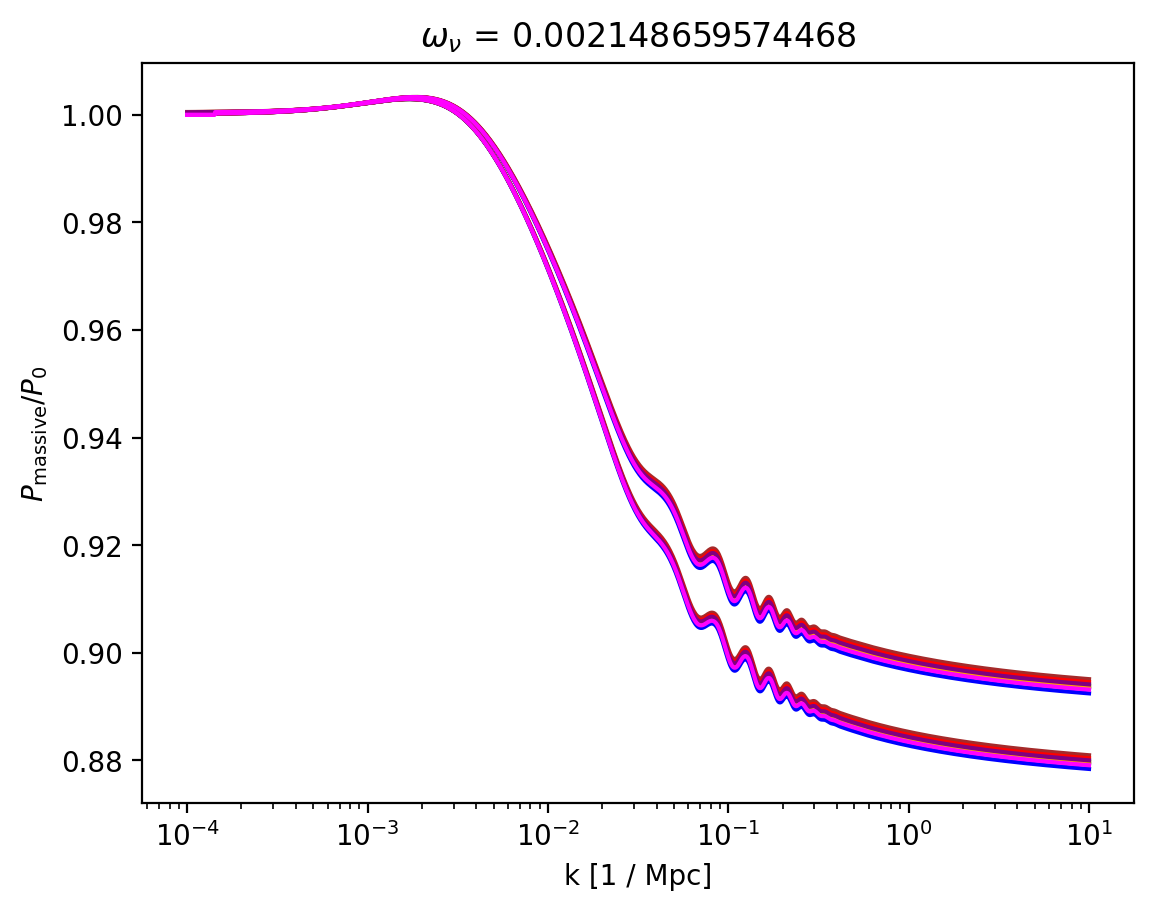

In [7]:
for modeli in range(len(spectra[omnuh2_float])):
    if spectra[omnuh2_float][modeli] is None:
        continue
    for snapi in range(len(spectra[omnuh2_float][modeli])):
        if spectra[omnuh2_float][modeli][snapi] is None:
            continue
        plt.plot(spectra[omnuh2_float][modeli][snapi]["k"],
            spectra[omnuh2_float][modeli][snapi]["P_nu"] / \
            spectra[omnuh2_float][modeli][snapi]["P_no"],
            label="model " + str(modeli) + ", no renormalizing, z=" + \
            str(ci.parse_redshifts(modeli)[snapi]),
                 c=ci.colors[modeli],
            linestyle=ci.styles[modeli])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(omnuh2_float))

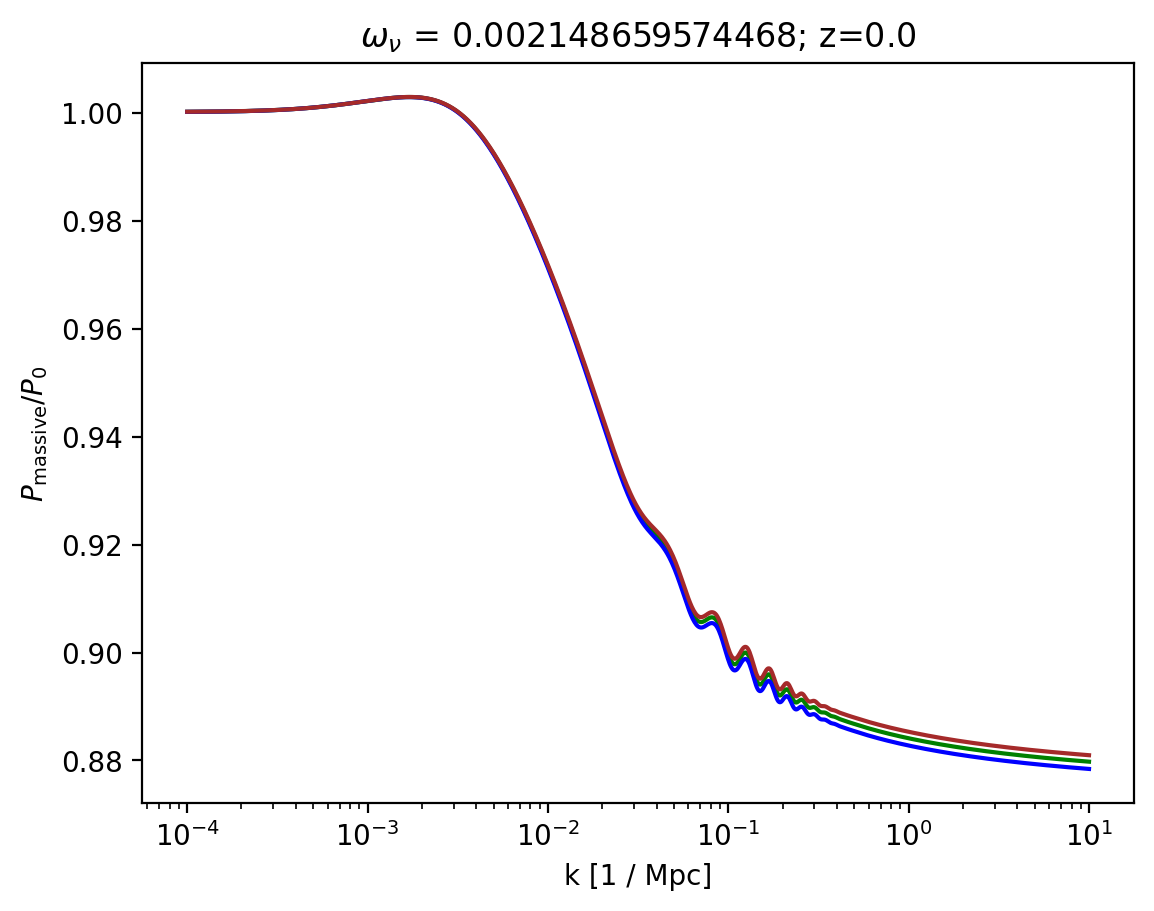

In [8]:
for modeli in range(0, 3):
    if spectra[omnuh2_float][modeli] is None:
        continue
    snapi = 4 # just look at z=0 before moving on
    plt.plot(spectra[omnuh2_float][modeli][snapi]["k"],
        spectra[omnuh2_float][modeli][snapi]["P_nu"] / \
        spectra[omnuh2_float][modeli][snapi]["P_no"],
        label="model " + str(modeli), c=ci.colors[modeli])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(omnuh2_float) + "; z=" + \
             str(spectra[omnuh2_float][modeli][snapi]["z"]))

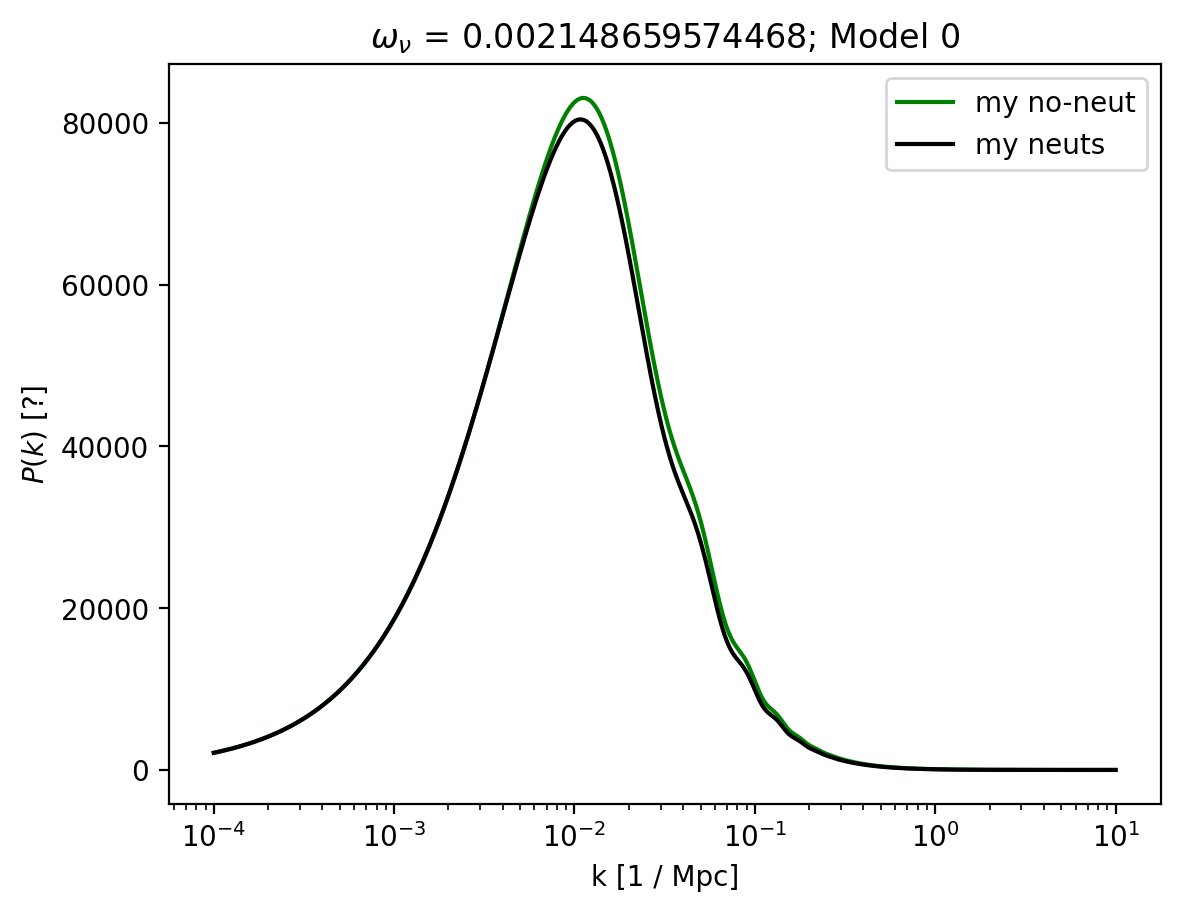

In [9]:
modeli = 0
snapi = 4
spectrum = spectra[omnuh2_float][modeli][snapi]

plt.plot(spectrum["k"], spectrum["P_no"], label="my no-neut",
         c=ci.colors[modeli])
plt.plot(spectrum["k"], spectrum["P_nu"], label="my neuts",
         c="black")
plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P(k)$ [?]")
plt.title(r"$\omega_\nu$ = " + str(omnuh2_float) + "; Model " + str(modeli))
plt.legend()

# This protects other cells by avoiding accidental reuse
del snapi, spectrum

In [10]:
modeli = 0
true3_early = powernu3[omnuh2_str][modeli][0]
true3_late = powernu3[omnuh2_str][modeli][4]
# The following construction makes indexing a little easier later.
true3 = [true3_early, None, None, None, true3_late]

[2.   1.   0.57 0.3  0.  ]


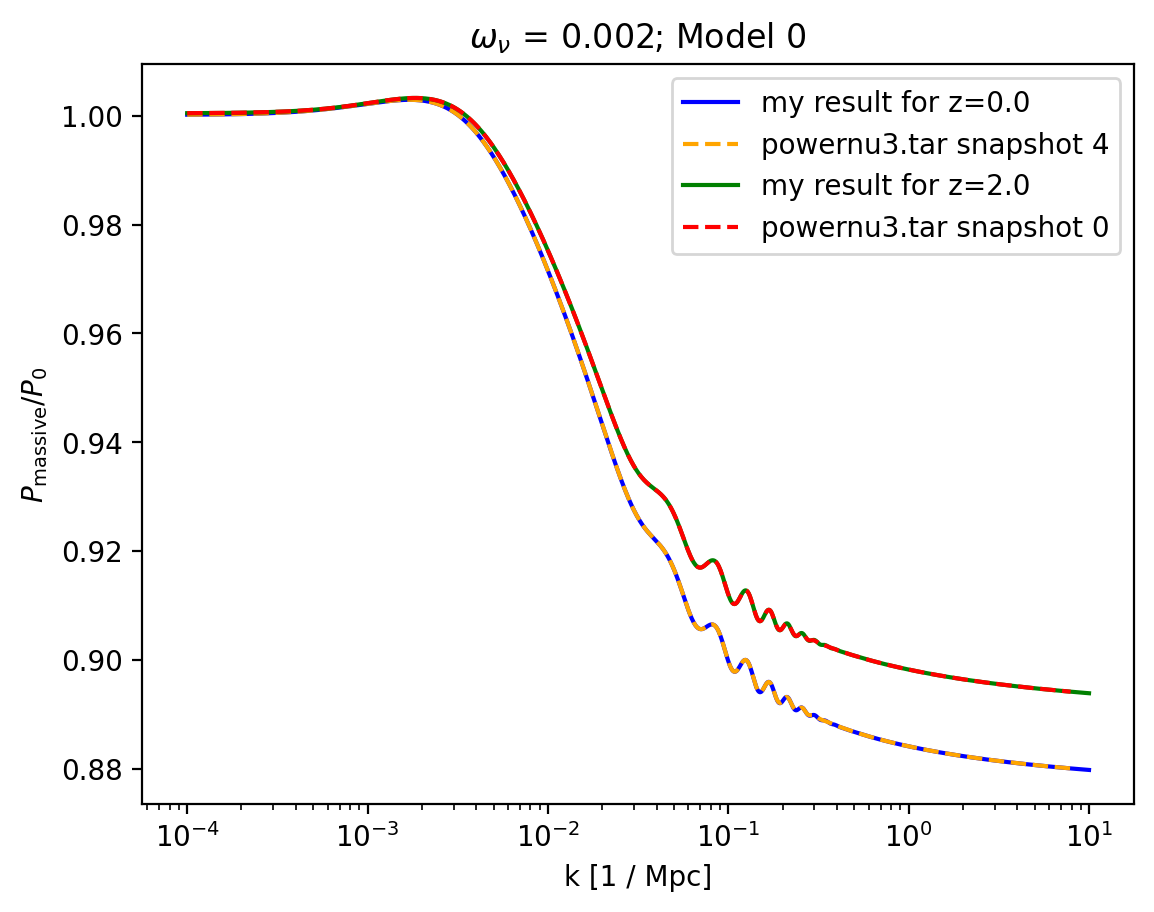

In [11]:
snapi = 4 # this should be SNAP index, not z index
z_list = ci.parse_redshifts(modeli)

print(z_list)
spectrum = spectra[omnuh2_float][modeli][snapi]
x_Lukas = spectrum["P_nu"] / spectrum["P_no"]

plt.plot(spectrum["k"], x_Lukas, c="blue",
    label="my result for z=" + str(z_list[snapi]))
plt.plot(true3[snapi]["k"], true3[snapi]["ratio"], c="orange",
         label="powernu3.tar snapshot " + str(snapi),
        linestyle="dashed")

snapi = 0
spectrum = spectra[omnuh2_float][modeli][snapi]
x_Lukas = spectrum["P_nu"] / spectrum["P_no"]

plt.plot(spectrum["k"], x_Lukas, c="green",
    label="my result for z=" + str(z_list[snapi]))
plt.plot(true3[snapi]["k"], true3[snapi]["ratio"], c="red",
         label="powernu3.tar snapshot " + str(snapi),
        linestyle="dashed")

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_\mathrm{massive} / P_0$")
plt.title(r"$\omega_\nu$ = " + omnuh2_str + "; Model " + str(modeli))
plt.legend()

# This protects other cells by avoiding unintended reuse
del snapi, spectrum

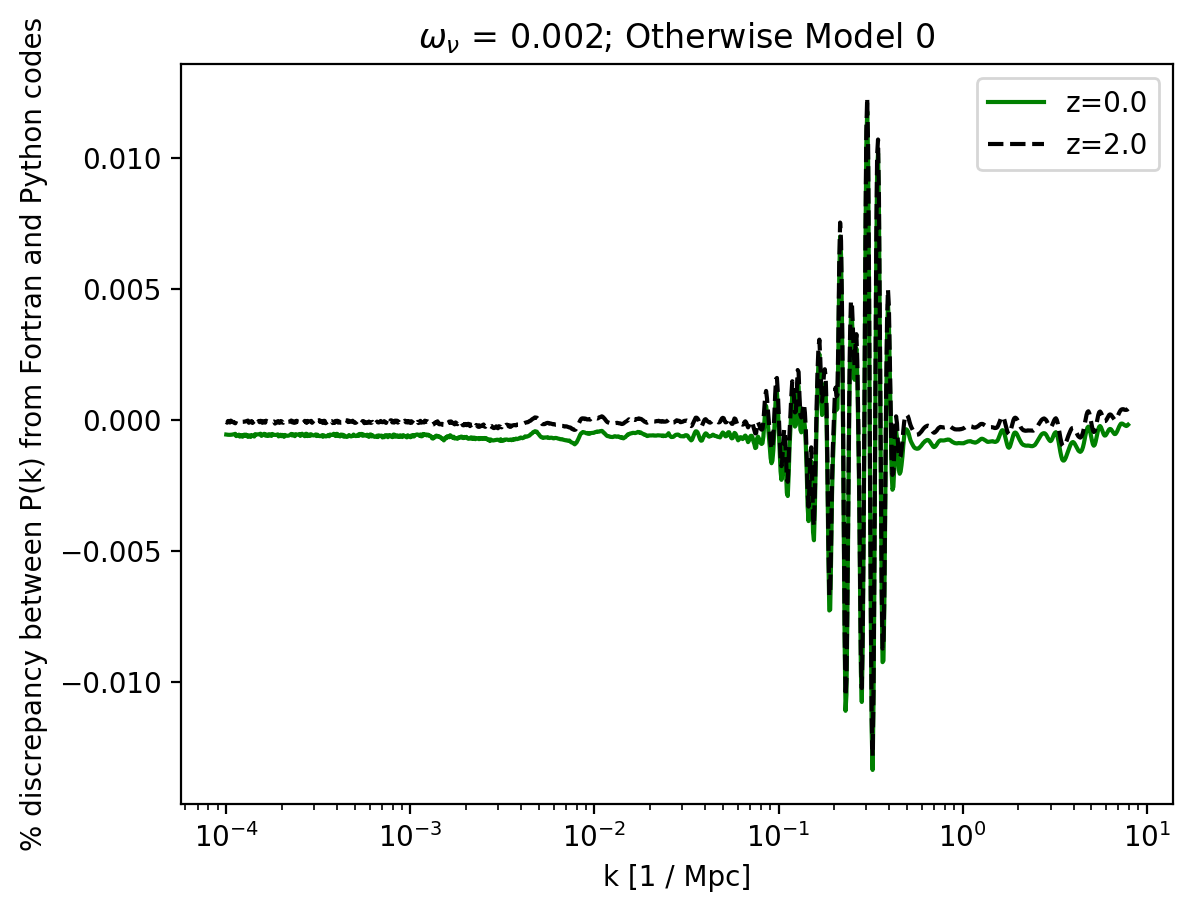

In [12]:
snapi = 4 # this should be SNAP index, not z index

spectrum = spectra[omnuh2_float][modeli][snapi]
x_Lukas = spectrum["P_nu"] / spectrum["P_no"]
x_Ariel = true3[snapi]["ratio"]

common_k, trunc_x_Ariel, aligned_x_Lukas = \
    ci.truncator(true3[snapi]["k"], x_Ariel,
             spectrum["k"], x_Lukas)

plt.plot(common_k,
         ui.percent_error(trunc_x_Ariel, aligned_x_Lukas),
         c=ci.colors[modeli], label="z=" + str(z_list[snapi]))

snapi = 0
spectrum = spectra[omnuh2_float][modeli][snapi]
x_Lukas = spectrum["P_nu"] / spectrum["P_no"]
x_Ariel = true3[snapi]["ratio"]

common_k, trunc_x_Ariel, aligned_x_Lukas = \
    ci.truncator(true3[snapi]["k"], x_Ariel,
             spectrum["k"], x_Lukas)

plt.plot(common_k,
    ui.percent_error(trunc_x_Ariel, aligned_x_Lukas),
    c="black", label="z=" + str(z_list[snapi]),
    linestyle="dashed")

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"% discrepancy between P(k) from Fortran and Python codes")
plt.title(r"$\omega_\nu$ = " + omnuh2_str + "; Otherwise Model " + str(modeli))
plt.legend()

# plt.savefig("../plots/camb_interface/accuracy/model0.png")
# This protects other cells by avoiding unintended reuse
del snapi, spectrum

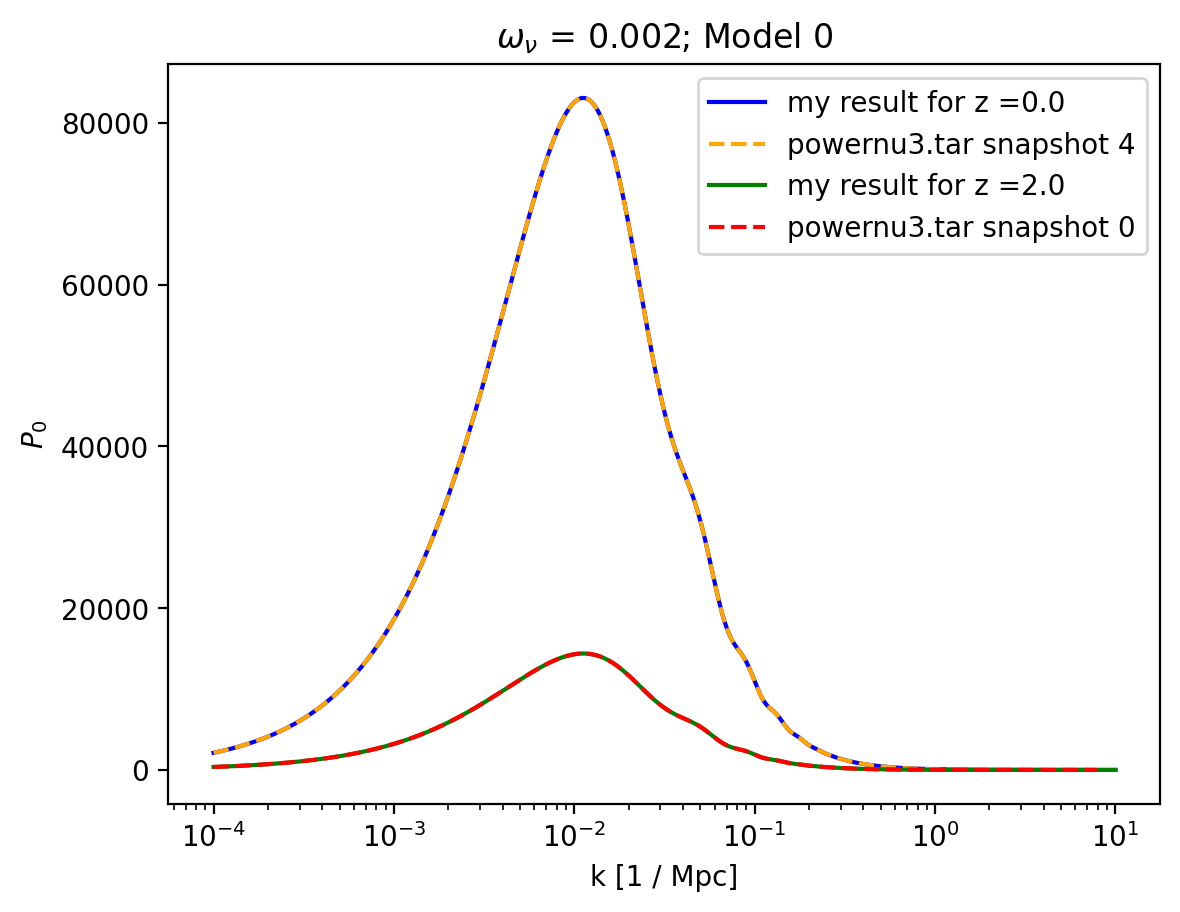

In [13]:
snapi = 4 # this should be SNAP index, not z index

spectrum = spectra[omnuh2_float][modeli][snapi]

plt.plot(spectrum["k"], spectrum["P_no"], c="blue",
    label="my result for z =" + str(z_list[snapi]))
plt.plot(true3[snapi]["k"], true3[snapi]["P_no"],
         c="orange", linestyle="dashed",
         label="powernu3.tar snapshot " + str(snapi))

snapi = 0
spectrum = spectra[omnuh2_float][modeli][snapi]

plt.plot(spectrum["k"], spectrum["P_no"], c="green",
    label="my result for z =" + str(z_list[snapi]))
plt.plot(true3[snapi]["k"], true3[snapi]["P_no"],
         c = "red", linestyle="dashed",
         label="powernu3.tar snapshot " + str(snapi))

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_0$")
plt.title(r"$\omega_\nu$ = " + omnuh2_str + "; Model " + str(modeli))
plt.legend()

# This protects other cells by avoiding unintended reuse
del snapi, spectrum

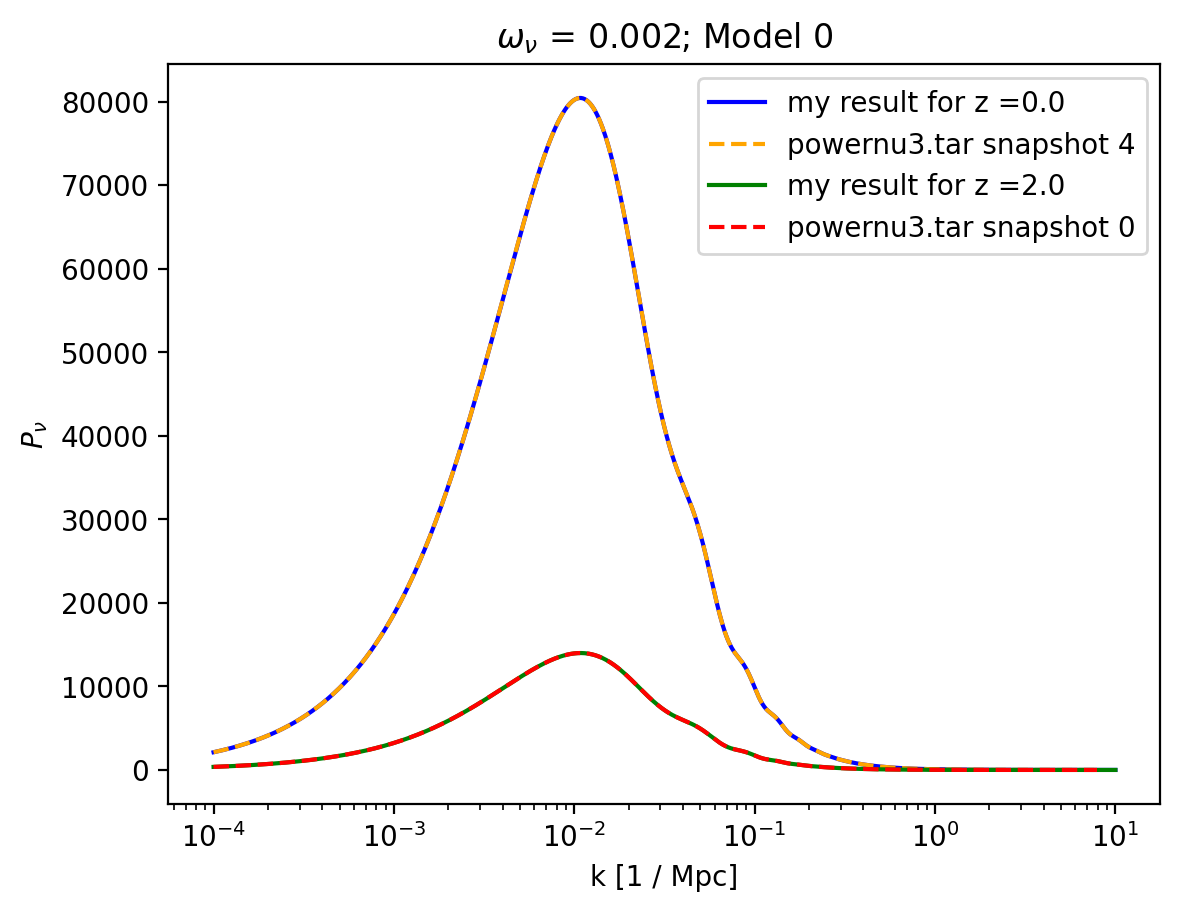

In [14]:
snapi = 4 # this should be SNAP index, not z index

spectrum = spectra[omnuh2_float][modeli][snapi]

plt.plot(spectrum["k"], spectrum["P_nu"], c="blue",
    label="my result for z =" + str(z_list[snapi]))
plt.plot(true3[snapi]["k"], true3[snapi]["P_nu"],
         c="orange", linestyle="dashed",
         label="powernu3.tar snapshot " + str(snapi))

snapi = 0
spectrum = spectra[omnuh2_float][modeli][snapi]

plt.plot(spectrum["k"], spectrum["P_nu"], c="green",
    label="my result for z =" + str(z_list[snapi]))
plt.plot(true3[snapi]["k"], true3[snapi]["P_nu"],
         c = "red", linestyle="dashed",
         label="powernu3.tar snapshot " + str(snapi))

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_\nu$")
plt.title(r"$\omega_\nu$ = " + omnuh2_str + "; Model " + str(modeli))
plt.legend()

# This protects other cells by avoiding unintended reuse
del snapi, spectrum

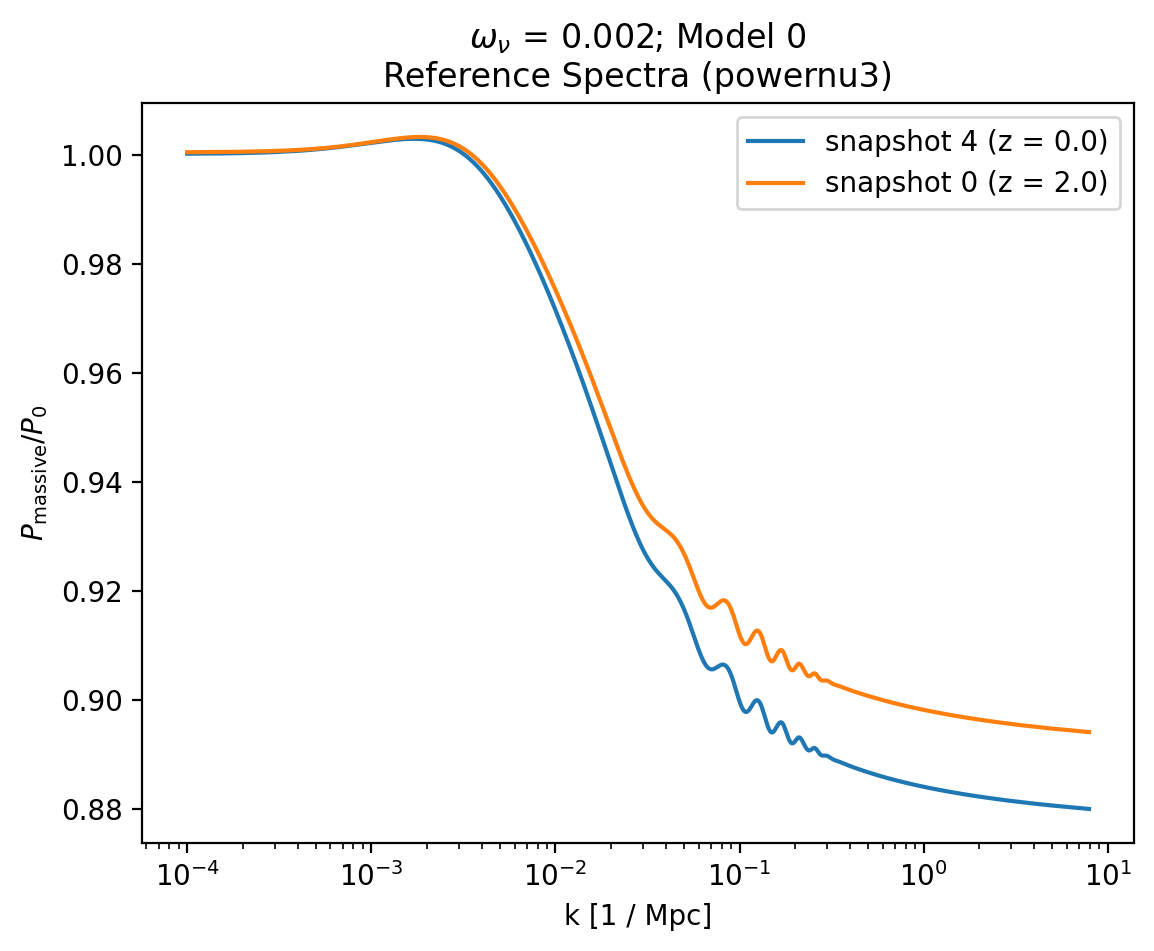

In [15]:
snapi = 4 # this should be SNAP index, not z index

plt.plot(true3[snapi]["k"], true3[snapi]["ratio"],
         label="snapshot " + str(snapi) + " (z = " + \
         str(z_list[snapi]) + ")")

snapi = 0 # This will correspond to z=0 for the model0 case.

plt.plot(true3[snapi]["k"], true3[snapi]["ratio"],
         label="snapshot " + str(snapi) + " (z = " + \
         str(z_list[snapi]) + ")")
         
plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_\mathrm{massive} / P_0$")
plt.title(r"$\omega_\nu$ = " + omnuh2_str + "; Model " + str(modeli) + \
        "\nReference Spectra (powernu3)")
plt.legend()

# This protects other cells by avoiding unintended reuse
del snapi